# Introduction
---

## Data Set Information

The problem includes 5 datasets, each of them defining a different learning problem:

* LP1: failures in approach to grasp position
* LP2: failures in transfer of a part
* LP3: position of part after a transfer failure
* LP4: failures in approach to ungrasp position
* LP5: failures in motion with part

## Attribute Information

All features are numeric although they are integer valued only. Each feature represents a force or a torque measured after failure detection; each failure instance is characterized in terms of **15 force/torque samples** collected at regular time intervals starting immediately after failure detection. *The total observation window for each failure instance was 315 ms*.

Each example is described as follows:

**class**\
Fx1 Fy1 Fz1 Tx1 Ty1 Tz1\
Fx2 Fy2 Fz2 Tx2 Ty2 Tz2\
......\
Fx15 Fy15 Fz15 Tx15 Ty15 Tz15

where Fx1 ... Fx15 is the evolution of force Fx in the observation window, the same for Fy, Fz and the torques; there is a **total of 90 features**.

---
---
# Imports

In [1]:
# ADD README.txt & Requirements.txt TO EXPLAIN INSTALLING LIBRARIES AND JUPYTER NOTEBOOK


# Importing OS module
import sys

# Data-processing function
from data_processing import process_data, class_dist, graph_observations, build_model

# Data-processing libraries
import pandas as pd
from glob import glob
import re

# Linear Algebra
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Algorithms
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

# Stats
from scipy import stats

# Set random seed for reproducibility
np.random.seed(0)
sns.set()  # Stylises graphs



In [2]:
import sys
import matplotlib
import scipy
import sklearn
import imblearn

print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}") 
print(f"scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"imblearn version: {imblearn.__version__}")

Python version: 3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]
pandas version: 1.1.0
matplotlib version: 3.3.0
NumPy version: 1.18.5
SciPy version: 1.5.4
scikit-learn version: 0.23.2
Seaborn version: 0.10.1
imblearn version: 0.7.0


---
---
# Data Processing

The below transforms the .data files provided into a format that is readable using a custom-made data-processing function.

In [3]:
# Calling the process_data function from data_processing.py
lp1 = process_data('./Dataset/lp1.data')
lp2 = process_data('./Dataset/lp2.data')
lp3 = process_data('./Dataset/lp3.data')
lp4 = process_data('./Dataset/lp4.data')
lp5 = process_data('./Dataset/lp5.data')

---
## Reading in the Data

In [4]:
# Checking that the lengths of each dataset are correct
print(f'LP1 Length: {len(lp1)}/88')
print(f'LP2 Length: {len(lp2)}/47')
print(f'LP3 Length: {len(lp3)}/47')
print(f'LP4 Length: {len(lp4)}/117')
print(f'LP5 Length: {len(lp5)}/164')

if (
    len(lp1) == 88 and
    len(lp2) == 47 and
    len(lp3) == 47 and
    len(lp4) == 117 and
    len(lp5) == 164
):
    print('\nAll Datasets are complete.')

LP1 Length: 88/88
LP2 Length: 47/47
LP3 Length: 47/47
LP4 Length: 117/117
LP5 Length: 164/164

All Datasets are complete.


---
## Null Values

Each dataset will be checked to see if any null rows are present, if they are then they will be removed from the datasets.

In [5]:
# Checking for any null values across the datasets
print(f'Number of missing values in lp1: {sum(lp1[lp1.columns].isnull().sum())}')
print(f'Number of missing values in lp2: {sum(lp2[lp2.columns].isnull().sum())}')
print(f'Number of missing values in lp3: {sum(lp3[lp3.columns].isnull().sum())}')
print(f'Number of missing values in lp4: {sum(lp4[lp4.columns].isnull().sum())}')
print(f'Number of missing values in lp5: {sum(lp5[lp5.columns].isnull().sum())}')

Number of missing values in lp1: 0
Number of missing values in lp2: 0
Number of missing values in lp3: 0
Number of missing values in lp4: 0
Number of missing values in lp5: 0


Since no null values are present, no rows or columns need to be removed.

---
## Duplicated Values

The datasets will now be checked for any duplicated rows.

In [6]:
# Checking for any duplicated values across the datasets
print(f"Duplicates in LP1: {lp1.duplicated().sum()}")
print(f"Duplicates in LP2: {lp2.duplicated().sum()}")
print(f"Duplicates in LP3: {lp3.duplicated().sum()}")
print(f"Duplicates in LP4: {lp4.duplicated().sum()}")
print(f"Duplicates in LP5: {lp5.duplicated().sum()}")

Duplicates in LP1: 0
Duplicates in LP2: 1
Duplicates in LP3: 1
Duplicates in LP4: 1
Duplicates in LP5: 1


There appears to be 1 duplicated row in each dataset apart from LP1, this will be investigated further.

In [7]:
# Checking duplicated rows for LP2
print("Duplicates for LP2: ")
lp2[lp2.duplicated(keep=False)]

Duplicates for LP2: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
44,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,back_col
45,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,back_col


In [8]:
# Checking duplicated rows for LP3
print("Duplicated rows for LP3: ")
lp3[lp3.duplicated(keep=False)]

Duplicated rows for LP3: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
44,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,slightly_moved
45,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,slightly_moved


In [9]:
# Checking duplicated rows for LP4
print("Duplicated rows for LP4: ")
lp4[lp4.duplicated(keep=False)]

Duplicated rows for LP4: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
24,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision
44,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision


In [10]:
# Checking duplicated rows for LP5
print("Duplicated rows for LP5: ")
lp5[lp5.duplicated(keep=False)]

Duplicated rows for LP5: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
71,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision_in_part
91,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision_in_part


As can be seen from the above, these duplicated rows in the datasets are exact copies of eachother. With such a small dataset and over 90 variables being measured, it is extremely unlikely that these are substantial and could skew the distribution of the classes when making the model.

These are most likely due to some kind of logging/data-collection error, so the second occurence for each duplicate will be removed from the datasets.

In [11]:
# Removing duplicates except for the first occurence
lp1 = lp1.drop_duplicates()
lp2 = lp2.drop_duplicates()
lp3 = lp3.drop_duplicates()
lp4 = lp4.drop_duplicates()
lp5 = lp5.drop_duplicates()

---
---
# Exploratory Data Analysis (EDA)

The data takes the form shown below, where each column represents a force or torque in one of the 3-coordinate axis (X, Y, Z) across the 15 time-steps as previously discussed.
```
normal
	-1	-1	63	-3	-1	0
	0	0	62	-3	-1	0
	-1	-1	61	-3	0	0
	-1	-1	63	-2	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	0	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	61	-3	0	0
	-1	-1	61	-3	0	0
	-1	-1	64	-3	-1	0
	-1	-1	64	-3	-1	0
	-1	-1	60	-3	0	0
	-1	0	64	-2	-1	0


normal
	-1	-1	63	-2	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	61	-3	0	0
	0	-4	63	1	0	0
	0	-1	59	-2	0	-1
	-3	3	57	-8	-3	-1
	-1	3	70	-10	-2	-1
	0	-3	61	0	0	0
	0	-2	53	-1	-2	0
	0	-3	66	1	4	0
	-3	3	58	-10	-5	0
	-1	-1	66	-4	-2	0
	-1	-2	67	-3	-1	0
	0	1	66	-6	-3	-1
	-1	-1	59	-3	-4	0
```

Before models can be effectively made for the 5 datasets, some initial EDA will be performed on the datasets to determine if there are any clear indicators for a certain classification.

For each classification in each dataset, the values of force and torque will be investigated to look for any corellation.

---
## Class Distribution

The class distribution for each dataset is shown below:

-- **LP1**: 24% normal,
           19% collision, 
           18% front collision,
           39% obstruction

   -- **LP2**: 43% normal,
           13% front collision,
           15% back collision,
           11% collision to the right,
           19% collision to the left

   -- **LP3**: 43% ok,
           19% slightly moved,
           32% moved,
            6% lost

   -- **LP4**: 21% normal,
           62% collision,
           18% obstruction

   -- **LP5**: 27% normal,
           16% bottom collision,
           13% bottom obstruction,
           29% collision in part,
           16% collision in tool


The frequency of each class across the datasets will be graphed below using the class_dist function in data_processing.py

In [12]:
# Setting a name for each dataset
lp1.name = 'LP1'
lp2.name = 'LP2'
lp3.name = 'LP3'
lp4.name = 'LP4'
lp5.name = 'LP5'

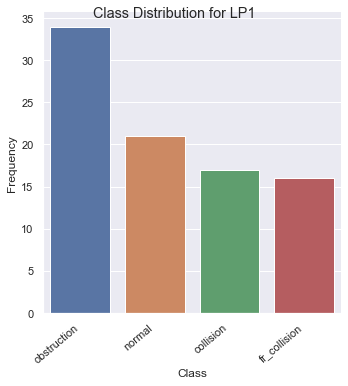

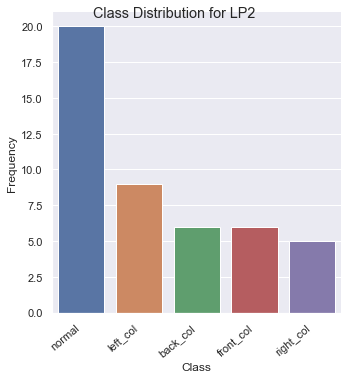

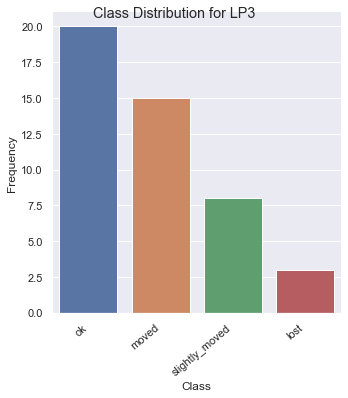

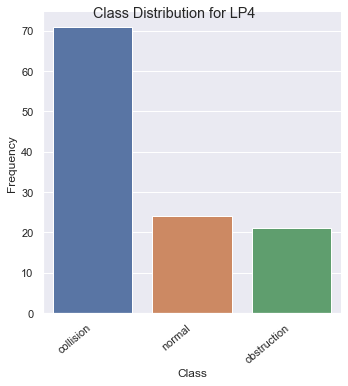

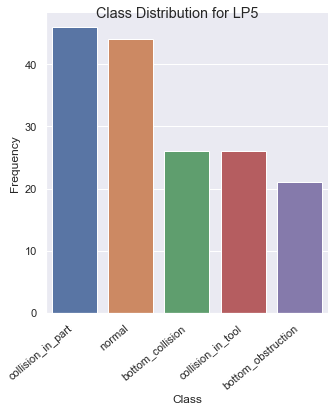

In [13]:
# Calling the class_dist function for each dataset
class_dist(lp1)
class_dist(lp2)
class_dist(lp3)
class_dist(lp4)
class_dist(lp5)

### Observations on Class Distribution

As can be seen from the above graphs, the classes are not evenly distributed. This could be extremely problematic when model building as it could create false levels of accuracy in the models.

The most problematic of these is the **'lost'** classification in LP3, having only 3 occurrences. If the dataset was split 80/20 training/testing, the testing dataset may not contain any **'lost'** classifications at all.

Also, if there is an extremely high distribution of one specific class, the model will likely overestimate it's accuracy. 

For example: If a dataset has 2 classes with distributions of 99% and 1% respectively, the model could predict the class with a distrubition of 99% for every classification and achieve an accuracy of 99%. When tested in a real world scenario, the model may perform extremely poorly as it will predict the 99% class every time; this will happen if the distribution of classes in the real world is not the same as in the dataset.

To solve these class imbalances there are several techniques that could be implemented, namely **Random Oversampling**, **Random Undersampling** and **SMOTE** which are explained further in the report. For this problem, **SMOTE** will be applied to the datasets to give more accurate results of the models.

---
## Force Type vs Time(ms)


A function was created in data_processing.py that automatically creates graphs for the selected dataset of the selected force type against time for all classifications in that dataset. The inputs are as follows: 
* **observation_types**: The classifications for the dataset (Automatically created, only the 'lpi' value needs to be changed, where i is the dataset number).
* **df**: The desired Dataset (lp1, lp2, lp3, lp4, lp5).
* **force**: The desired force type (Fx, Fy, Fz, Tx, Ty, Tz)

Plotting these graphs is important as it allows for better understanding of what the parameters look like for a given dataset, allowing for better models to be created.

Plotting all combinations for each dataset would result in 30 subplots of graphs, to make the file more readable only one subplot of graphs will be displayed with instructions on how to change the displayed subplots. To find all the subplots please refer to **Appendix** in the report file.

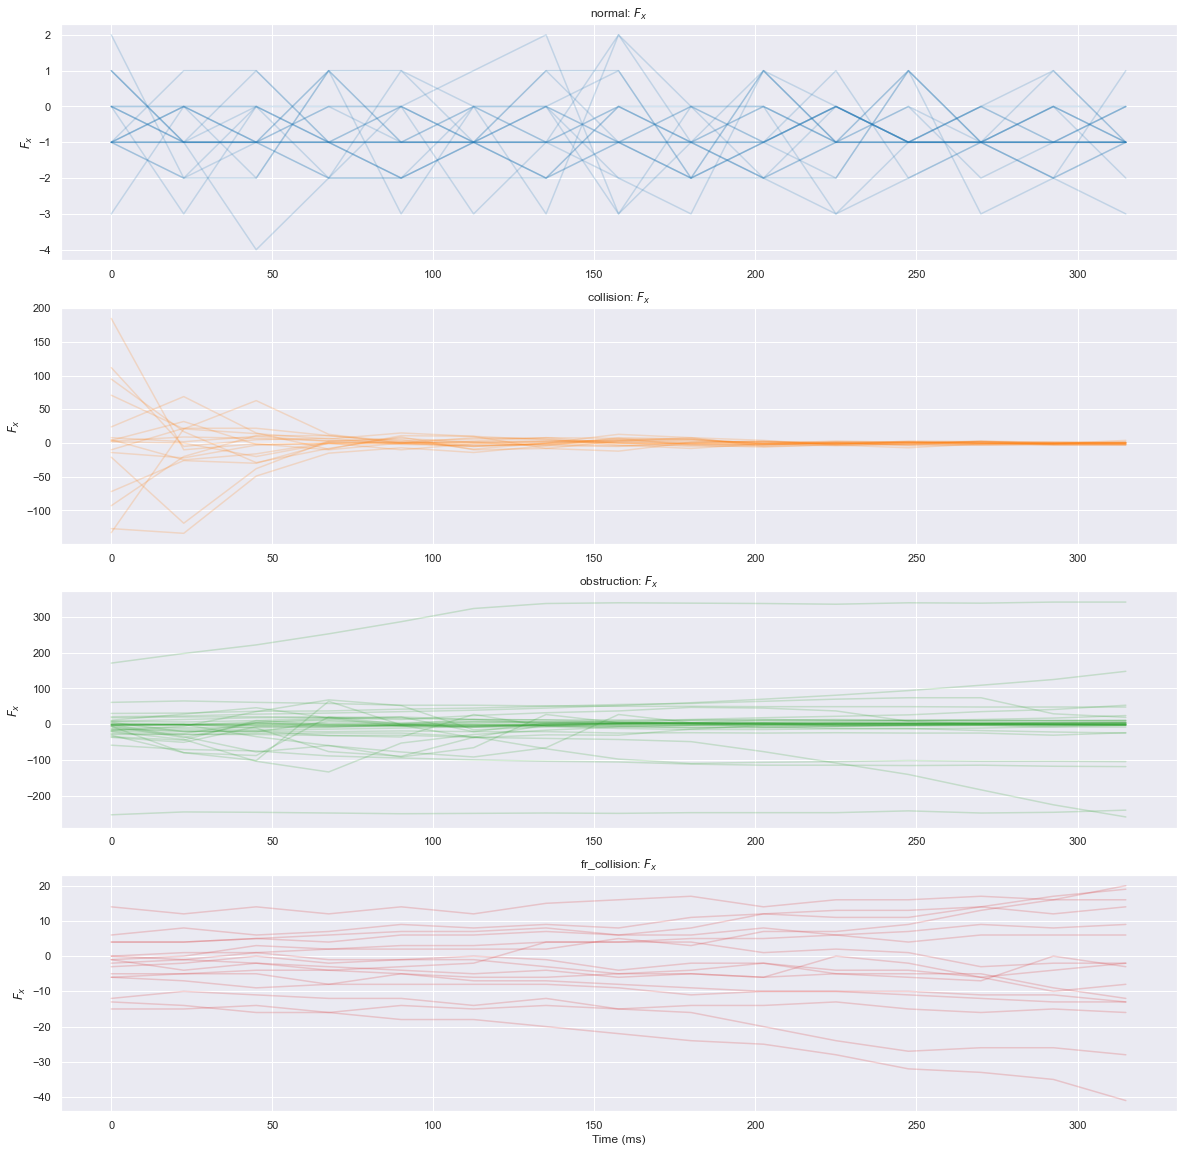

In [14]:
# Defining which classifications should be used
# To change the dataset, change the 'i' in 'lpi' in the line "observation_types = lpi['label'].unique()"
# Where i is the dataset number
observation_types = lp1['label'].unique()

# Calling the graph_observations function from data_processing.py
graph_observations(
    # Defines which dataset should be used, to change the dataset change df = lpi, where i is the dataset number
    df=lp1,
    # Defines the observation types, as classified above
    observation_types=observation_types,
    # Defines the force to be plotted out of, Fx, Fy, Fz, Tx, Ty, Tz
    force='Fx'
)

### Observations

Even from this one subplot, there are a few observations that can be made. 

The first observation from this subplot is that the $F_x$ values for the **'normal'** class vary significantly less than the other classifications over time, with a range of: **2 $\ge$ $F_x$ $\ge$ -4**. If the graph for the **'normal'** class shared a similar sized y-axis to the other classifications, it would appear as a thick straight line of approximately **y = 0**.

The $F_x$ values for the **'collision'** class are clearly significantly different. With a general trend of the 1st, 2nd or 3rd datapoints being extremely high or low, before tending towards a value of **y = 0**.

The $F_x$ values for the **'obstruction'** class are harder to draw conclusions from, however they still display a significantly different trend than the other classifications. Similar to the **'collision'** class, the values tend towards a value of **y = 0** at the end of the time-steps. However, there is more variation in the data between the beginning and end of the time-steps than in the **'collision'** class. $F_x$ may not be the best parameter to determine an **'obstruction'** class.

The $F_x$ values for the **'fr_collision'** class show much less variation in values than both the **'collision'** and **'obstruction'** classes but significantly more variation than the **'normal'** class. The values appear to be more static over the time-steps than either the **'collision'** or **'obstruction'** classes.

From just this one subplot many observations can be drawn which would help with model building. If this was done for all subplots across each dataset it could help in determining some parameters that could be removed using dimensionality reduction techniques. As the datasets are required to be organised in a high-dimensional space to create models, they may suffer some statistical phenomena due to the **Curse of Dimensionality**. Performing dimensionality reduction could help alleviate some of these issues.

---
---
# Model Building

The model building section is split up separately for each dataset. Before any models are built, a brief overview of each model that is being used will be given as shown below.

## Logistic Regression (?)

## Random Forest Classification


## XGBoost Classification


## K-Nearest Classification


## Naive Bayes


## SVM - Linear Kernel


## SVM - RBF Kernel


## Artificial Neural Network - Feed Forward

---

## Data Encoding

Before models can be constructed, the datasets must be encoded as only numerical data can be read by the models.

This section will encode the original datasets and store them in dictionaries. The encoding will be done in two methods:

* **Multi-class**: Where the original classes from the dataset are kept and encoded using OneHotEncoding.
* **Binary-class**: Where the classes are converted to a binary problem, with 'normal' or 'ok' classifications being considered 1 and all 'failure' classifications being considered 0.

Since the datasets are so small simplifying the problem to a binary classification may improve the results achieved, however the specific failure classification can no longer be determined. Results from both methods will be compared and discussed in the **report**.

Below, a list of the datasets is created to be iterated over and the dictionaries are setup to store the encoded datasets.

In [15]:
# Creating a list of all the datasets
datasets = [lp1, lp2, lp3, lp4, lp5]

# Creating a dictionary for multi-class classification
multi_class_datasets = {
    'output_cols': [],
    'input_cols': [],
    'datasets': []
}

# Creating a dictionary for binary-class classification
binary_class_datasets = {
    'output_cols': [],
    'input_cols': [],
    'datasets': []
}

### Multi-Class Encoding - OneHotEncoding (OHE)

This section encodes the datasets using OneHotEncoding where $n$ columns are added to the dataset, with: 

$n$ = Number of classification types

The new columns contain a 0 or 1 to determine the presence or absence of that classification.

*OneHotEncoding* is used in this instance instead of *Label Encoding*. When using multiple classifications in *Label Encoding*, each classification is given an integer value based on their alphabetical ordering. As such, the classification that comes last in the alphabetical ordering will be given a higher integer value. This can cause the model to falsely determine a relationship between the classifications such that:

*Last Classification Alphabetically*  $>$  *First Classification Alphabetically*

Using OneHotEncoding 

In [16]:
# Iterates over all datasets in datasets[]
for dataset in datasets:
    # Prevents the datasets being iterated over too many times
    if len(multi_class_datasets['datasets']) >= 5:
        print('Encoding has already been run.')
        print('If you wish to alter the dataset, please re-run the notebook or the cell above.')
        break
    else:
        # Creating copies of the datasets, stops it editing the
        # original dataset
        dataset = dataset.copy()
        # Using OneHotEncoding on the 'label' column
        multi_labels = pd.get_dummies(dataset['label'])
        # Setting the output column names (?)
        output_cols = multi_labels.columns
        # Appending the input columns to the dictionary
        multi_class_datasets['input_cols'].append(
            dataset.drop('label', axis=1).columns
        )
        # Adding the encoded labels to the dataset
        dataset[output_cols] = multi_labels
        # Appending the output columns to the dictionary
        multi_class_datasets['output_cols'].append(output_cols)
        # Removing the old label column from the dataset
        dataset = dataset.drop('label', axis=1)
        # Appending the encoded dataset to the dicitionary
        multi_class_datasets['datasets'].append(dataset)

### Binary-Class Encoding - Label Encoding

In [17]:
# Iterates over all datasets in datasets[]
for dataset in datasets:
    # Prevents the datasets being iterated over too many times
    if len(binary_class_datasets['datasets']) >= 5:
        print('Encoding has already been run.')
        print('If you wish to alter the dataset, please re-run the notebook or the cell above.')
        break
    else:
        # Creating copies of the datasets, stops it editing the
        # original dataset
        dataset = dataset.copy()
        # Creating, WHY IS THIS HERE???
        labels = dataset['label']
        # Appending output columns to the dictionary
        binary_class_datasets['output_cols'].append(['label'])
        # Encoding the data to 1 for 'normal' or 'ok'
        # 0 for all other failure modes
        dataset['label'] = [
            1 if label == 'normal' or label == 'ok' else 0
            for label in dataset['label']
        ]
        # Appending the input columns to the dictionary
        binary_class_datasets['input_cols'].append(
            dataset.drop('label', axis=1).columns
        )
        # Appending the modified dataset to the dictionary
        binary_class_datasets['datasets'].append(dataset)

In [18]:
# MULTI-CLASS
multi_zipped_dict = zip(
    multi_class_datasets['datasets'],
    multi_class_datasets['input_cols'],
    multi_class_datasets['output_cols'],
    ['LP1', 'LP2', 'LP3', 'LP4', 'LP5']
)

In [19]:
# SINGLE-CLASS
binary_zipped_dict = zip(
    binary_class_datasets['datasets'],
    binary_class_datasets['input_cols'],
    binary_class_datasets['output_cols'],
    ['LP1', 'LP2', 'LP3', 'LP4', 'LP5']
)

---
## Class Rebalancing - SMOTE

As previously discussed, the datasets being used contain quite severe class imbalances. To aid with model building **SMOTE** will be applied to the datasets. **SMOTE** will be applied inside the build_model function in the data_processing.py file. **SMOTE** should only be applied to the training dataset to prevent the training dataset containing synthesised values.

## Data Scaling

WE JUST DO IT FOR ONE DATA SET FORT DEMONSTRATION PURPOSES ONLY
adf;pjawfjioji3fo2irtnhilt2i


In [32]:
ss = StandardScaler()

lp1 = binary_class_datasets['datasets'][0].copy()
lp1_input = binary_class_datasets['input_cols'][0]

lp1[lp1_input] = ss.fit_transform(
    lp1[lp1_input]
)

---
## PCA

**PCA** is a dimensionality reduction technique which can be extremely useful for high-dimensional data, as in this dataset.

**PCA** must be applied to both the training and testing dataset. This is done separately as performing **PCA** on the entire dataset will cause data leakage resulting in the training dataset containing some data that is also in the test dataset; this means the test dataset no longer contains purely unseen data so the behaviour of the model cannot be properly analysed.

**PCA** does have some drawbacks in that the explainability of the model is vastly decreased, this is discussed further in the **report**.

The optimal number of PCs will be analysed by plotting a Scree plot, this optimal value will then be used for the models (with the option to run the models without PCA).

In [40]:
pca.fit_transform(lp1[lp1_input]).shape

(88, 25)

In [47]:
n_components = 25
pca = PCA(n_components=n_components)
pca.fit(lp1[lp1_input])

PCA(n_components=25)

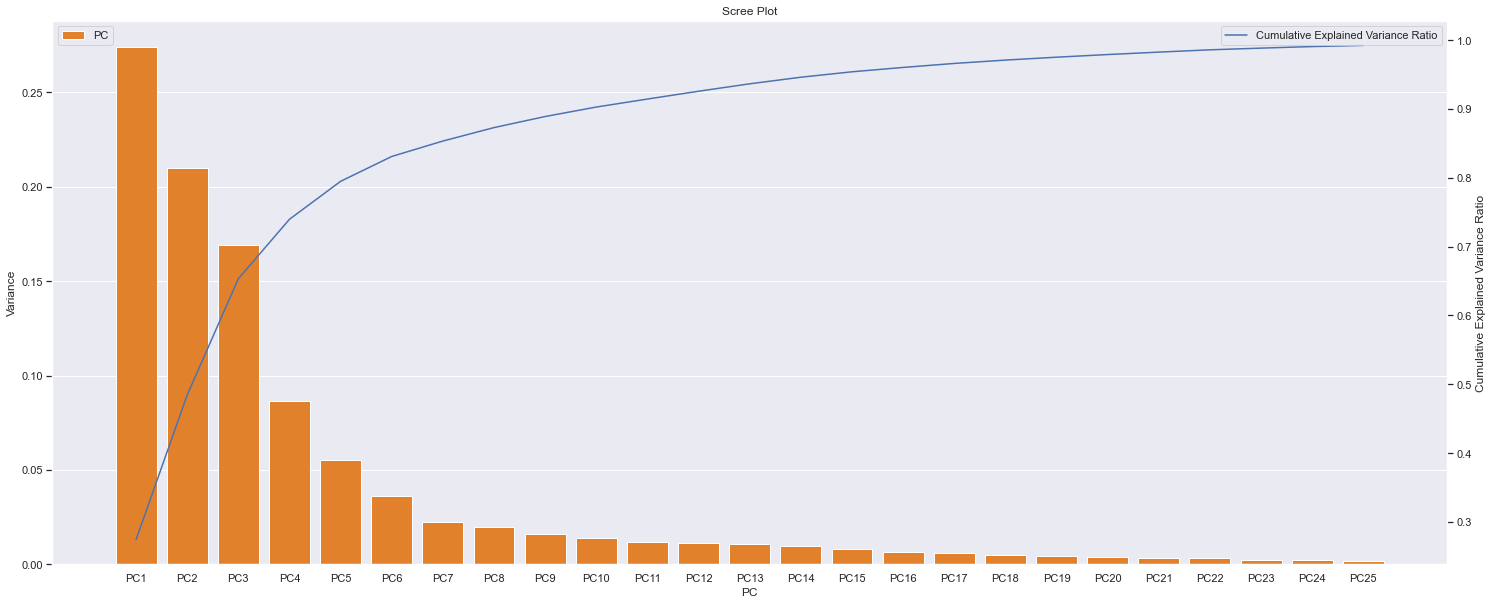

In [67]:
pc_cols = [f'PC{n}' for n in range(1, n_components + 1)]
pc_var_df = pd.DataFrame(
    {
        'Variance': pca.explained_variance_ratio_,
        'PC': pc_cols
    }
)

fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()

sns.barplot(
    x='PC', y='Variance',
    data=pc_var_df,
    label='PC',
    color='tab:orange',
    ax=ax1
)
ax2.plot(
    np.cumsum(pca.explained_variance_ratio_),
    label='Cumulative Explained Variance Ratio'
)

plt.title('Scree Plot')
ax2.set_ylabel('Cumulative Explained Variance Ratio')

ax1.legend(loc=2)
ax2.legend()
ax2.grid(b=None)
plt.show()

In [69]:
pc_var_df.head()

,Variance,PC
0,0.274310,PC1
1,0.210024,PC2
2,0.169032,PC3
3,0.086373,PC4
4,0.055172,PC5


---
## Random Forest Classification

In [21]:
# Setting hyperparameters
params = {
    # Number of trees in random forest
    'classifier__n_estimators': range(2, 600, 70),
    # Number of features to consider at every split, MAYBE ADD 'log2'
    'classifier__max_features': ['auto'],
    # Maximum number of levels in tree
    'classifier__max_depth': range(2, 25),
    # Minimum number of samples required to split a node
    'classifier__min_samples_split': range(2, 10),
    # Minimum number of samples required at each leaf node
    'classifier__min_samples_leaf': range(1, 10),
    # Method of selecting samples for training each tree
#    'classifier__bootstrap': [True, False]
}

### 'Normal' or 'Failure'

In [25]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=RandomForestClassifier,
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Number of dimensions for PCA
        # if pca=0, PCA is not performed on the dataset
        pca=0,
        # Number of iterations to determine best params
        n_iter=50,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=False
    )
    print('=' * 125)

### All Failure Modes

In [26]:
# NOT WORKING, WHY?
for dataset, input_cols, output_cols, name in multi_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        df=dataset,
        classifier=RandomForestClassifier,
        hyperparams=params.keys(),
        cv=1,
        smote=True,
        pca=0,
        n_iter=200,
        input_cols=input_cols,
        output_cols=output_cols,
        verbose=False
    )
    print('=' * 125)

Dataset: LP2


TypeError: Parameter distribution is not a dict ('classifier__n_estimators')

In [ ]:
classifier = RandomForestClassifier

pipeline = Pipeline([
            ('classifier', classifier(random_state=0))
        ])

In [ ]:
get_params(RandomForestClassifier)

### Discussion

Comment on results, assume it's a large dataset.

---
## Next Model

---
---
# Model Interpretability

**USE ELI5**, IF ELI5 Doesn't work for NN, explain Black box etc etc

# YOU'RE DONE BOIIIIIIII